In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import seaborn as sns

%matplotlib inline

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    col_names= ['CA','UNIT','SCP','STATION','LINENAME','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, sep=",", header=0, names = col_names, parse_dates=[['DATE', 'TIME']]))
    return pd.concat(dfs)
        
week_nums = [190504, 190511, 190518, 190525]
df = get_data(week_nums)

In [3]:
df['day_of_week'] = df['DATE_TIME'].dt.dayofweek

In [4]:
df = df[df.DESC == 'REGULAR']

In [5]:
df.columns

Index(['DATE_TIME', 'CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DESC', 'ENTRIES', 'EXITS', 'day_of_week'],
      dtype='object')

In [12]:
HOURLY_ENTRIES = df.ENTRIES - df.ENTRIES.shift(1)
df['HOURLY_ENTRIES'] = HOURLY_ENTRIES.fillna(0)

HOURLY_EXITS = df.EXITS - df.EXITS.shift(1)
df['HOURLY_EXITS'] = HOURLY_ENTRIES.fillna(0)


In [15]:
HOURLY_SUM  = df.HOURLY_ENTRIES + df.HOURLY_EXITS
df['HOURLY_SUM'] = HOURLY_SUM

In [23]:
#df['HOUR'] = df['DATE_TIME'].map(int(time.split(':')[0]))
df['MONTH'] = df['DATE_TIME'].dt.month
# df['YEAR'] = df['DATE_TIME'].map(date_to_year)

In [24]:
df.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_SUM,MONTH
0,2019-04-27 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035249,2384833,5,0.0,0.0,0.0,4
1,2019-04-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035269,2384840,5,20.0,20.0,40.0,4
2,2019-04-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035292,2384875,5,23.0,23.0,46.0,4
3,2019-04-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035392,2384951,5,100.0,100.0,200.0,4
4,2019-04-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035651,2385020,5,259.0,259.0,518.0,4


In [25]:
df['HOURLY_ENTRIES'] = df.groupby(['SCP','MONTH']).HOURLY_ENTRIES.transform(lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))

df['HOURLY_EXITS'] = df.groupby(['SCP','MONTH']).HOURLY_EXITS.transform(lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))

df['HOURLY_SUM'] = df.HOURLY_ENTRIES + df.HOURLY_EXITS 

In [26]:
df.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_SUM,MONTH
0,2019-04-27 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035249,2384833,5,0.0,0.0,0.0,4
1,2019-04-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035269,2384840,5,20.0,20.0,40.0,4
2,2019-04-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035292,2384875,5,23.0,23.0,46.0,4
3,2019-04-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035392,2384951,5,100.0,100.0,200.0,4
4,2019-04-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035651,2385020,5,259.0,259.0,518.0,4


In [33]:
top_15_stations_with_sum = df.groupby(['STATION'])['HOURLY_SUM'].sum().sort_values(ascending = False).head(15)
print(top_15_stations_with_sum)

STATION
34 ST-PENN STA     8.613890e+06
GRD CNTRL-42 ST    7.221449e+06
34 ST-HERALD SQ    5.843900e+06
23 ST              5.712006e+06
14 ST-UNION SQ     5.497323e+06
TIMES SQ-42 ST     4.982114e+06
42 ST-PORT AUTH    4.954800e+06
FULTON ST          4.908310e+06
86 ST              4.599814e+06
125 ST             3.939400e+06
59 ST COLUMBUS     3.725683e+06
CANAL ST           3.712232e+06
59 ST              3.283305e+06
96 ST              3.269018e+06
14 ST              3.160782e+06
Name: HOURLY_SUM, dtype: float64


In [34]:
top_15_stations_with_sum.head(16)

STATION
34 ST-PENN STA     8.613890e+06
GRD CNTRL-42 ST    7.221449e+06
34 ST-HERALD SQ    5.843900e+06
23 ST              5.712006e+06
14 ST-UNION SQ     5.497323e+06
TIMES SQ-42 ST     4.982114e+06
42 ST-PORT AUTH    4.954800e+06
FULTON ST          4.908310e+06
86 ST              4.599814e+06
125 ST             3.939400e+06
59 ST COLUMBUS     3.725683e+06
CANAL ST           3.712232e+06
59 ST              3.283305e+06
96 ST              3.269018e+06
14 ST              3.160782e+06
Name: HOURLY_SUM, dtype: float64

In [35]:
top_15 = list(top_15_stations_with_sum.index[:])

In [36]:
top_15

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '23 ST',
 '14 ST-UNION SQ',
 'TIMES SQ-42 ST',
 '42 ST-PORT AUTH',
 'FULTON ST',
 '86 ST',
 '125 ST',
 '59 ST COLUMBUS',
 'CANAL ST',
 '59 ST',
 '96 ST',
 '14 ST']

In [39]:
df_top_15 = df[df['STATION'].isin(top_15)]

In [40]:
df_top_15['STATION'].nunique()

15

In [41]:
df_top_15.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_SUM,MONTH
0,2019-04-27 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035249,2384833,5,0.0,0.0,0.0,4
1,2019-04-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035269,2384840,5,20.0,20.0,40.0,4
2,2019-04-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035292,2384875,5,23.0,23.0,46.0,4
3,2019-04-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035392,2384951,5,100.0,100.0,200.0,4
4,2019-04-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7035651,2385020,5,259.0,259.0,518.0,4


In [43]:
gb_station_top15 = df_top_15.groupby(['STATION'])['HOURLY_SUM'].sum().sort_values(ascending=False).head(15)

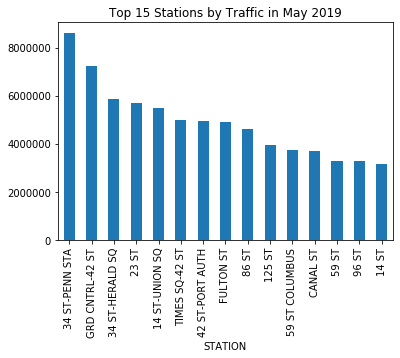

In [44]:
gb_station_top15.plot(kind='bar',title= "Top 15 Stations by Traffic in May 2019")

In [48]:
df_top_5 = df_top_15[df_top_15['STATION'].isin(['86 ST','59 ST COLUMBUS','23 ST','14 ST-UNION SQ','CANAL ST'])]

In [49]:
gb_station_top5 = df_top_5.groupby(['STATION'])['HOURLY_SUM'].sum().sort_values(ascending=False).head(15)

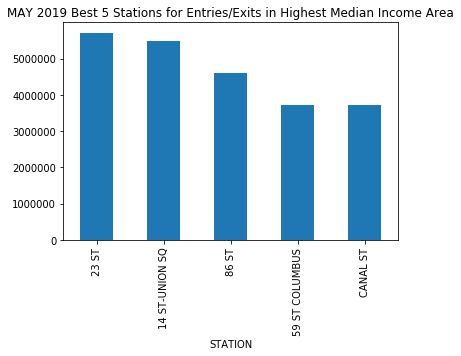

In [51]:
gb_station_top5.plot(kind='bar',title= "MAY 2019 Best 5 Stations for Entries/Exits in Highest Median Income Area")

In [52]:
df_top_5.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,day_of_week,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_SUM,MONTH
3876,2019-04-27 00:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,65840,5,161.968031,161.968031,323.936063,4
3877,2019-04-27 04:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,65846,5,0.000000,0.000000,0.000000,4
3878,2019-04-27 08:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,65899,5,0.000000,0.000000,0.000000,4
3879,2019-04-27 12:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,66056,5,0.000000,0.000000,0.000000,4
3880,2019-04-27 16:00:00,A030,R083,01-00-00,23 ST,NRW,BMT,REGULAR,53384,66332,5,0.000000,0.000000,0.000000,4


In [53]:
gb_station_top5_by_day_of_week = df_top_5.groupby(['day_of_week'])['HOURLY_SUM'].sum().head(15)

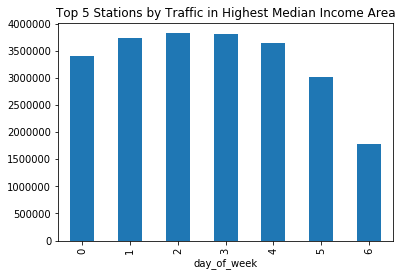

In [54]:
gb_station_top5_by_day_of_week.plot(kind='bar',title= "Top 5 Stations by Traffic in Highest Median Income Area")